In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic, bic
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [3]:
emotions = ["anger", "fear", "sadness", "none", "irony", "love", "joy"]

In [4]:
def loadAlphas(windowSize: int=8, songNum: int=2):
    path = f"./alphas/windowSize_{windowSize}/{songNum}_alphas.pickle"
    with open(path, 'rb') as f:
        return pickle.load(f)

In [5]:
def plotSeries(series: pd.Series):
    _, ax = plt.subplots(figsize=(8, 1.8))
    ax.plot(series.to_numpy())
    ax.set_xlabel("t")
    ax.set_ylabel("alpha")
    ax.set_title(f"Time Series for {series.name}")
    plt.show()

In [6]:
# Based on https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/
def augmentedDickeyFuller(series: pd.Series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # .dropna() handles differenced data
    labels = [
        'ADF test statistic',
        'p-value',
        '# lags used',
        '# observations'
    ]
    print(result)
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())  # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
def cointegrationTest(df: pd.DataFrame, alpha=0.10):
    out = coint_johansen(df, -1, 5)
    d = {0.90: 0, 0.95: 1, 0.99: 2}
    traces = out.lr1
    cvts = out.cvt[:, d[1-alpha]]
    def adjust(val, length=6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--' * 20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

In [14]:
def myVAR(df: pd.DataFrame, criterion: str="aic", maxLag=10):
    test_len = 10
    train = df[:-test_len]
    test = df[-test_len:]

    model = VAR(train)
    criterions = {
        'aic': [],
        'bic': [],
        'fpe': [],
        'hqic': []
    }
    for i in range(1, maxLag+1):
        result = model.fit(i)
        criterions["aic"].append(result.aic)
        criterions["bic"].append(result.bic)
        criterions["fpe"].append(result.fpe)
        criterions["hqic"].append(result.hqic)
    optimal_i = np.argmin(criterions[criterion]) + 1
    model_fitted = model.fit(optimal_i)
    print(model_fitted.summary())
    model_fitted.plot()
    model_fitted.plot_acorr()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Mar, 2023
Time:                     11:57:28
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -61.7452
Nobs:                     87.0000    HQIC:                  -63.5230
Log likelihood:           2056.24    FPE:                7.98828e-29
AIC:                     -64.7213    Det(Omega_mle):     2.62354e-29
--------------------------------------------------------------------
Results for equation anger
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.023647         0.112310           -0.211           0.833
L1.anger           1.279363         0.116199           11.010           0.000
L1.fear            0.091981         0.111200            0.827           

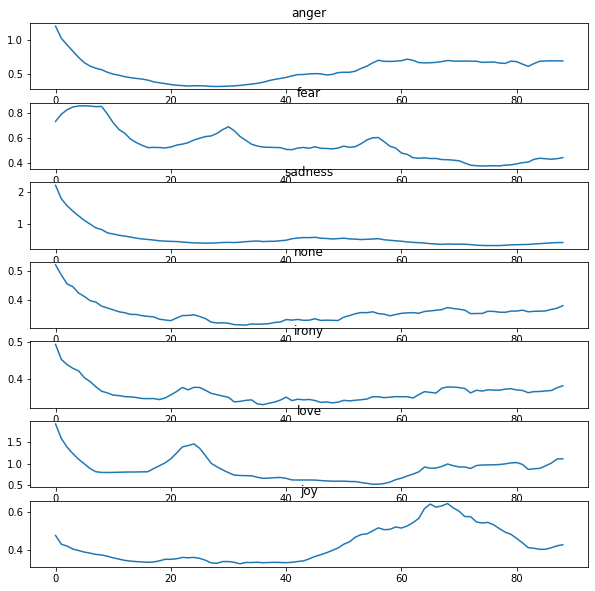

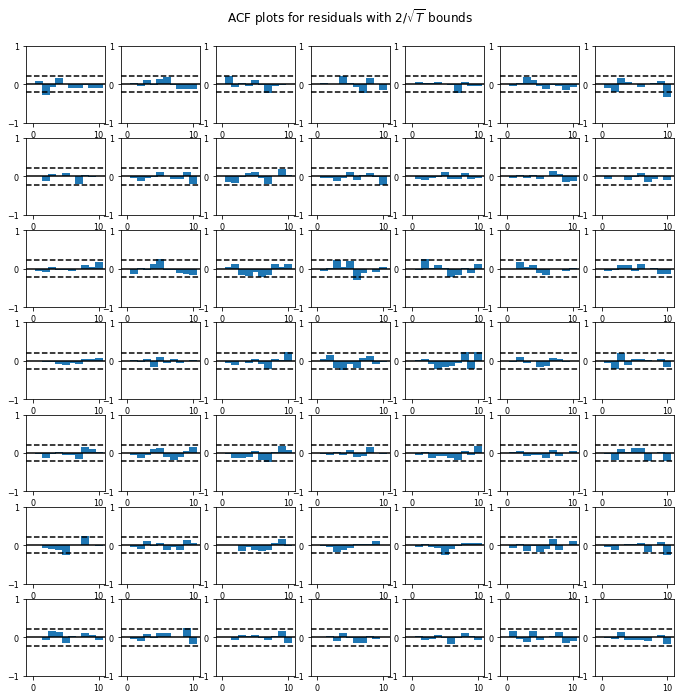

In [20]:
alphas: pd.DataFrame = loadAlphas(32, 3).dropna()[emotions]
alphas_diff = alphas.diff().dropna()[emotions]
# cointegrationTest(alphas_diff.dropna()[emotions])
myVAR(alphas, criterion="bic", maxLag=4)
# myVAR(alphas_diff, criterion="bic")